In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp


from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from tqdm.notebook import tqdm_notebook, tnrange

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

### Multi-dimensional convolution (MDC)



The so-called multi-dimensional convolution (MDC) is a chained operator. It is composed of a forward Fourier transform a multi-dimensional integration (as shown in equation below) and an inverse Fourier transform:
    
$$ d(s,v,f) = \int_S R(s,r,f) m(v,r,f) dr$$

This operation can be discretized and performed by means of a linear operator

$$\mathbf{G}= \mathbf{F}^H  \mathbf{R} \mathbf{F}$$

where $\mathbf{F}$ is the Fourier transform applied along the time axis  and $\mathbf{R}$ is multi-dimensional convolution kernel espressed in the equation above.

Let's start considering a single virtual source

In [ ]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]

ns = par['ny']
nr = par['nx']
nt = par['nt']
nfmax = par['nfmax']
dr = par['dx']
ds = par['dy']
dt = par['dt']
f0 = par['f0']

# Create taper for operator
tap = taper3d(nt, (ns,nr), [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0)[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
G,Gwavoriginal = np.zeros((ns,nr,nt)), - \
         np.zeros((ns,nr,nt))
for iy,y0 in enumerate(y):
    G[iy],Gwavoriginal[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)
G,Gwavoriginal = G*tap,Gwavoriginal*tap

In [ ]:
Gwav = Gwavoriginal.copy()

In [ ]:
# Add negative part to operator and model
ns = Gwav.shape[0]
m     = np.concatenate((np.zeros((nr, nt-1)), m), axis=-1).T
mwav  = np.concatenate((np.zeros((nr, nt-1)), mwav), axis=-1).T
Gwav2 = np.concatenate((np.zeros((ns, nr, nt-1)), Gwav), axis=-1)


In [ ]:
# Create frequency domain operator
Gwav_fft = np.fft.rfft(Gwav2, 2*nt-1, axis=-1)
Gwav_fft = Gwav_fft[...,:nfmax]
Gwav_fft = Gwav_fft.transpose(2,0,1)

# Create operator
MDCop=MDC(Gwav_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, 
          twosided=True, transpose=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=3, verb=True)

# Create data
d = MDCop*m.flatten()
d = d.reshape(2*nt-1, ns)

Dot test passed, v^T(Opu)=-4770.172202+4046.896423i - u^T(Op^Tv)=-4770.172202+8132.717211i


In [ ]:
# gradient function

def evaluate_gradient(batch, d,minv,nfmax,lm,dr,dt,nt,batch_size, type = float):
  Gwav_fft = np.fft.rfft(batch, 2*nt-1, axis=-1)
  Gwav_fft = Gwav_fft[...,:nfmax]
  MDCop1 = MDC(Gwav_fft.transpose(2,0,1), nt = 2*nt-1, nv=1, dt=dt, dr=dr, twosided = True,transpose = False)
 
  
  data1=MDCop1*minv.flatten()
  data1= data1.reshape(2*nt-1, batch_size)

  res = d - data1
  cost= np.sum(np.power((res),2))

  grad = (-2*MDCop1.H*res.flatten()) + 2*lm*minv.flatten()
  grad = grad.reshape(2*nt-1,nr)

  return grad, cost


In [ ]:
# mini batch gradient function

def mini_gd(Gwav, d, minv, nfmax, lr, dt, dr, nt, lm, n_epochs, batch_size):

  no_of_batches=Gwav.shape[0]//batch_size
  for i_epoch in tqdm_notebook(range(n_epochs), desc = 'No.of.Epochs'):
      
      for i in range(no_of_batches):
        mini_batch = Gwav[i*batch_size:(i+1)*batch_size,:]
        minibatch.append(mini_batch)
        d_batch = d[:,i*batch_size:(i+1)*batch_size]
        dbatch.append(d_batch)

      for batch, dbatch1 in zip(minibatch, dbatch):     
        grad, cost= evaluate_gradient(batch, dbatch1, minv, nfmax = nfmax, lm=lm,dt=dt, dr=dr, nt=nt, batch_size= batch_size)
        c.append(cost)
        minv = minv.flatten() - (lr * grad.flatten())
        minv = minv.reshape(2*nt-1,nr)
  
  
  return grad, c, minv

In [ ]:
# Creating a dictionary to store cost function
cost_dict = {}

In [ ]:
#1 Assigning the gradient

dt= 0.004
dr =10
nt=400
lr =0.00001
lm = 0.001
n_epochs = 10
nfmax = 200
batch_size= 75


minibatch=[]
dbatch =[]
c=[]

minv = np.zeros((m.shape[0], m.shape[1]))

grad, c, minv = mini_gd(Gwav2, d, minv, nfmax, lr, dt, dr, nt, lm, n_epochs, batch_size)

cost_dict["batch_size = 75 , epochs = 10"] = c

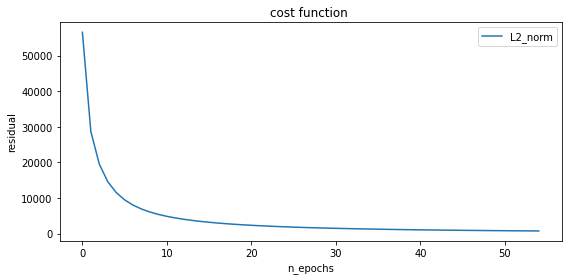

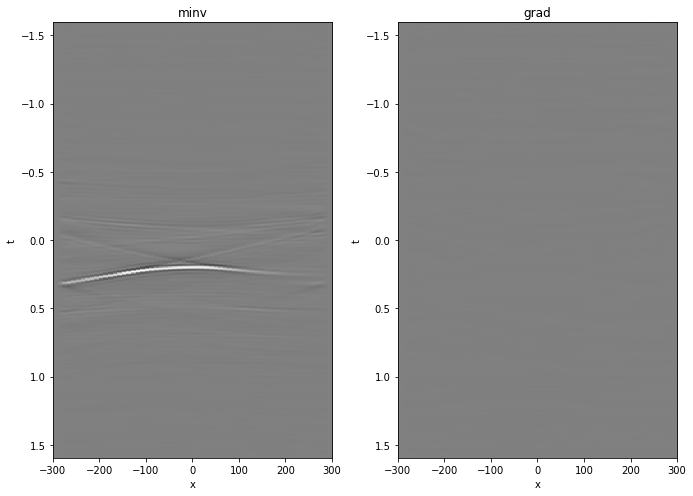

In [ ]:
fig = plt.figure(figsize= (8,4))
plt.plot(c, label = 'L2_norm')
plt.title('cost function ', fontsize=12)
plt.xlabel('n_epochs')
plt.ylabel('residual')
plt.legend()
plt.tight_layout()


fig = plt.figure(figsize= (12,7))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax1.imshow(minv, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('minv', fontsize=12)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(grad*lr, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))

ax2.set_title('grad', fontsize=12)
ax2.set_xlabel('x'),ax2.set_ylabel('t')
fig.tight_layout()

In [ ]:
#2 Assigning the gradient

dt= 0.004
dr =10
nt=400
lr =0.00001
lm = 0.001
n_epochs = 10
nfmax = 200
batch_size= 50


minibatch=[]
dbatch =[]
c=[]

minv = np.zeros((m.shape[0], m.shape[1]))

grad, c, minv = mini_gd(Gwav2, d, minv, nfmax, lr, dt, dr, nt, lm, n_epochs, batch_size)

cost_dict["batch_size = 50, epochs = 10"] = c

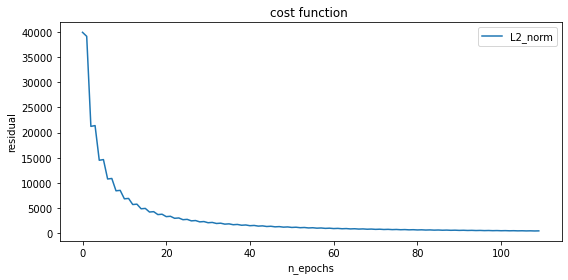

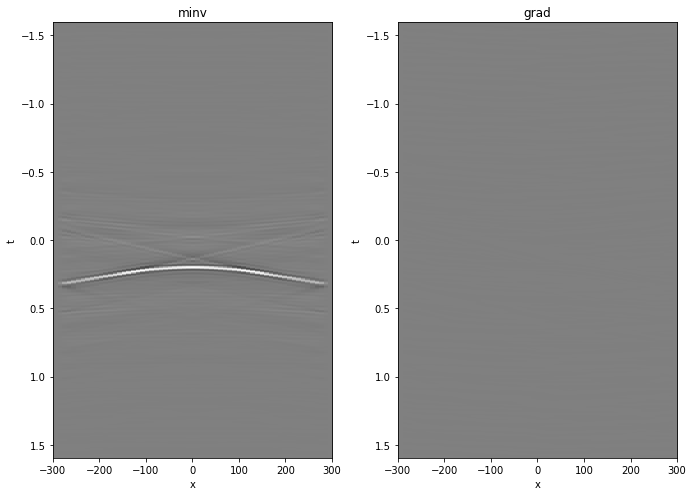

In [ ]:
fig = plt.figure(figsize= (8,4))
plt.plot(c, label = 'L2_norm')
plt.title('cost function ', fontsize=12)
plt.xlabel('n_epochs')
plt.ylabel('residual')
plt.legend()
plt.tight_layout()


fig = plt.figure(figsize= (12,7))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax1.imshow(minv, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('minv', fontsize=12)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(grad*lr, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))

ax2.set_title('grad', fontsize=12)
ax2.set_xlabel('x'),ax2.set_ylabel('t')
fig.tight_layout()

In [ ]:
#3 Assigning the gradient

dt= 0.004
dr =10
nt=400
lr =0.00001
lm = 0.001
n_epochs = 10
nfmax = 200
batch_size= 25


minibatch=[]
dbatch =[]
c=[]

minv = np.zeros((m.shape[0], m.shape[1]))

grad, c, minv = mini_gd(Gwav2, d, minv, nfmax, lr, dt, dr, nt, lm, n_epochs, batch_size)

cost_dict["batch_size = 25, epochs = 10"] = c

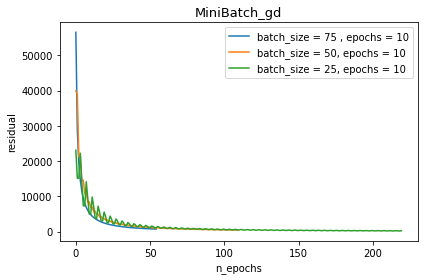

In [ ]:
# Plotting the different cost function in dictionary

for cname in cost_dict.keys():
  plt.plot(cost_dict[cname], label = cname)
plt.title("MiniBatch_gd", fontsize = 13)
plt.xlabel('n_epochs')
plt.ylabel('residual')
plt.legend()
plt.tight_layout()

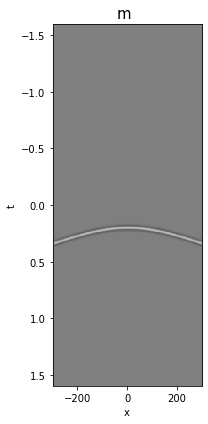

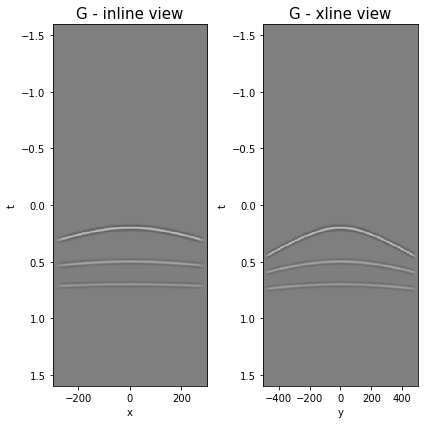

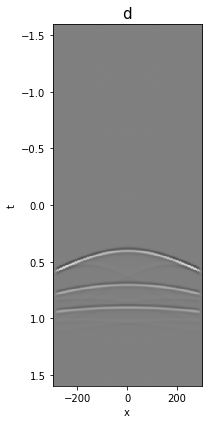

In [ ]:
# D, G - inline view, G-xline view, model
# Plotting
plt.figure(figsize=(3, 6))
plt.imshow(mwav,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x')
plt.ylabel('t')
plt.tight_layout()

plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(Gwav2[int(ns/2)].T,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.subplot(122)
plt.imshow(Gwav2[:,int(nr/2)].T,aspect='auto',interpolation='nearest', vmin=-2, vmax=2, cmap='gray',
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

plt.figure(figsize=(3, 6))
plt.imshow(d, aspect='auto',interpolation='nearest', vmin=-20, vmax=20, cmap='gray',
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

## Application 1: Multi-dimensional deconvolution (MDD)

MDD is an ill-solved problem, well-known in the image processing and geophysical community. It aims to remove the effect of the multidimensional convolution kernel or the so-called point-spread function (PSF). It can be written as

$$\mathbf{d}= \mathbf{D} \mathbf{m}$$

or, equivalently, by means of its normal equation

$$\mathbf{m}= (\mathbf{D}^H\mathbf{D})^{-1} \mathbf{D}^H\mathbf{d}$$

where $\mathbf{D}^H\mathbf{D}$ is generally referred to as blurring operator or PSF.

### Single virtual source

Let's take from where we left and invert our MDC operator. This is done directly using the LSQR solver

In [ ]:
madj = MDCop.H*d.flatten()
minv, istop, itn, r1norm, r2norm = lsqr(MDCop, d.ravel(), damp=1e-10, iter_lim=10, show=1)[0:5]

madj = madj.reshape(2*nt-1, nr)
minv = minv.reshape(2*nt-1, nr)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has    80699 rows  and    48739 cols
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.836e+02  2.836e+02    1.0e+00  4.6e-01
     1  0.00000e+00   1.840e+02  1.840e+02    6.5e-01  6.8e-01   1.7e+02  1.0e+00
     2  0.00000e+00   1.267e+02  1.267e+02    4.5e-01  4.2e-01   2.5e+02  2.4e+00
     3  0.00000e+00   9.672e+01  9.672e+01    3.4e-01  2.9e-01   3.2e+02  3.8e+00
     4  0.00000e+00   7.788e+01  7.788e+01    2.7e-01  2.2e-01   3.7e+02  5.4e+00
     5  0.00000e+00   6.362e+01  6.362e+01    2.2e-01  1.9e-01   4.1e+02  7.2e+00
     6  0.00000e+00   5.448e+01  5.448e+01    1.9e-01  1.6e-01   4.5e+02  9.0e+00
     7  0.00000e+00   4.695e+01  4.695e+01    1.7e-01  1.3e-01   4.8e+02  1.1e+01
     8  0.00000e+00   4.039e

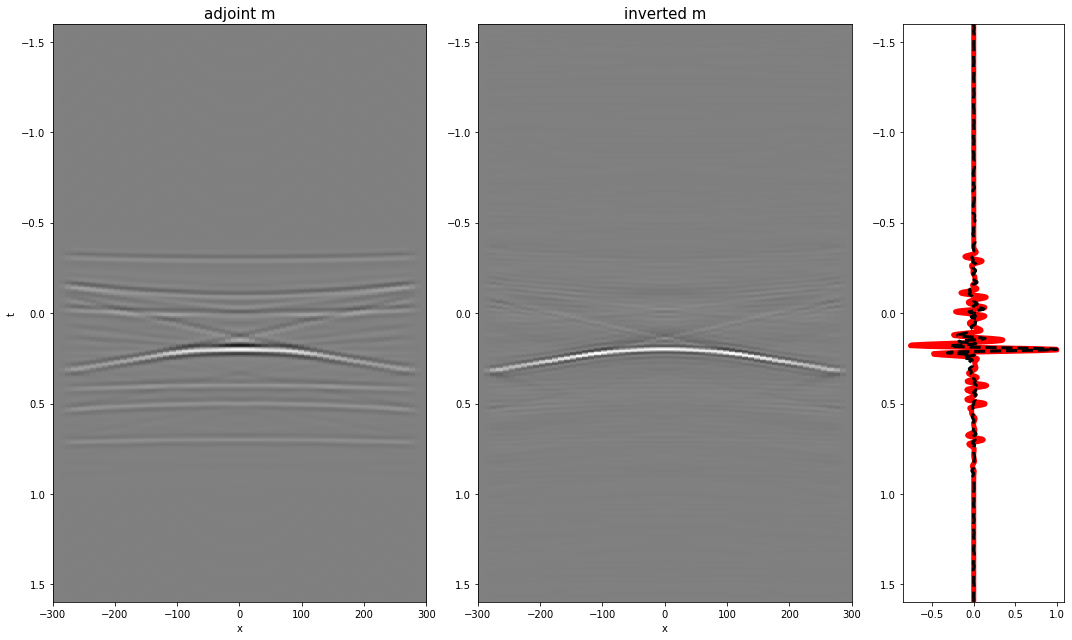

In [ ]:
# Plotting
fig = plt.figure(figsize=(15, 9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(madj, aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-madj.max(), vmax=madj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(minv, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-minv.max(), vmax=minv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')

ax3.plot(madj[:, int(nr/2)]/np.abs(madj[:, int(nr/2)]).max(), t2, 'r', lw=5)
ax3.plot(minv[:, int(nr/2)]/np.abs(minv[:, int(nr/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()